Contains working code

last modified 20 Nov

for updated functions code see FeatureExtraction.py

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neo
import os
from scipy import stats


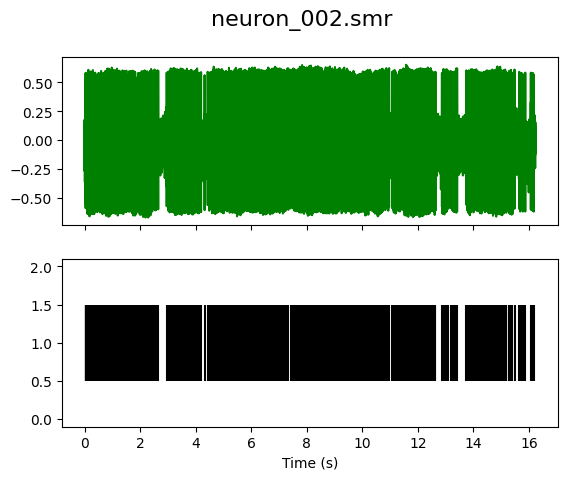

In [13]:

##### CHANGE THIS TO YOUR DIRECTORY #####

path = '/Users/jazlynn/Downloads/neurons-smr-format-sorted' # Enter the path where the .smr files are located on your computer
filename = "neuron_002.smr" # Name of the file including the extension (.smr)

##### IMPORT .SMR DATA STRUCTURE INTO PYTHON (DO NOT CHANGE) #####
os.chdir(path)
reader = neo.io.Spike2IO(filename)
block = reader.read(lazy=False)[0]
segments = block.segments[0]

analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
sampling_frequency = float(segments.analogsignals[0].sampling_rate) # the number of samples per second (in Hz)
time = np.arange(0,len(analogsignal))/sampling_frequency # time vector

##### PLOT SIGNALS #####

fig, ax = plt.subplots(2, sharex = True, )
fig.suptitle(filename, fontsize=16)    

ax[0].plot(time,analogsignal,'green')
ax[1].eventplot(spike_times, color='black')
ax[1].set_xlabel("Time (s)")

plt.show()

### firing rate
Over entire recording

In [9]:
def get_firing_rate(spike_times, recording, sampling_rate):
    num_spikes = len(spike_times)
    fr = num_spikes / (len(recording) / sampling_rate)
    
    
    
    return fr

fr = get_firing_rate(spike_times, analogsignal, sampling_frequency)
fr


136.41666666666669

In [135]:
spike_times

array([ 0.03584,  0.03784,  0.04296,  0.04496,  0.04608,  0.09568,
        0.11576,  0.138  ,  0.15648,  0.1788 ,  0.20368,  0.21992,
        0.24008,  0.2716 ,  0.28632,  0.30032,  0.3484 ,  0.38544,
        0.456  ,  0.50568,  0.55672,  0.59768,  0.64576,  0.67776,
        0.71256,  0.73832,  0.75872,  0.77648,  0.79408,  0.80688,
        0.82072,  0.82904,  0.8424 ,  0.85616,  0.86992,  0.88168,
        0.89672,  0.91712,  0.92992,  0.95   ,  0.96192,  0.98152,
        1.0024 ,  1.01896,  1.04192,  1.06576,  1.09088,  1.10664,
        1.12664,  1.14648,  1.17008,  1.19464,  1.21704,  1.23304,
        1.25432,  1.27776,  1.30608,  1.34248,  1.3708 ,  1.3956 ,
        1.42336,  1.45272,  1.47696,  1.50832,  1.57728,  1.60696,
        1.6312 ,  1.6512 ,  1.66992,  1.6852 ,  1.70832,  1.7236 ,
        1.73712,  1.76   ,  1.77272,  1.78832,  1.80336,  1.82408,
        1.8632 ,  1.93368,  1.95128,  1.97392,  1.98976,  2.01592,
        2.03376,  2.05368,  2.08048,  2.0996 ,  2.11416,  2.13

In [140]:
time_bins = np.arange(0, len(analogsignal)/sampling_frequency, 0.5)
window = 1
for bin in time_bins:
        print(np.nonzero((spike_times > bin) & (spike_times < bin + window)).shape)
        ifr = len(np.nonzero((spike_times > bin) & (spike_times < bin + window))) / window
        print(ifr)

AttributeError: 'tuple' object has no attribute 'shape'

In [149]:
len(spike_times)/(len(analogsignal)/sampling_frequency)

35.22948436845607

8.281326399675828


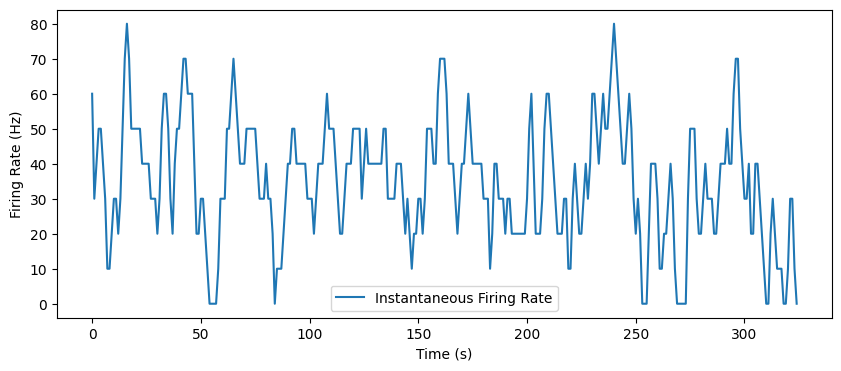

In [14]:
def calculate_instantaneous_firing_rate(spike_times, recording, sampling_rate, step_size, window):
    time_bins = np.arange(0, len(recording)/sampling_rate, step_size)
    
    ifr_ls = [len(np.nonzero((spike_times > bin) & (spike_times < bin + window))[0]) / window for bin in time_bins]
    
    ifr_mean = np.mean(ifr_ls)
    ifr_var = np.var(ifr_ls)
    fano_factor = ifr_var / ifr_mean
    
    # ifr_ls = []
    # for bin in time_bins:
    
    #     ifr = len(np.nonzero((spike_times > bin) & (spike_times < bin + window))) / window
    #     print(ifr)
    #     ifr_ls.append(ifr)
    return ifr_ls, time_bins, ifr_mean, ifr_var, fano_factor

# Calculate instantaneous firing rate
ifr, time_bins, ifr_mean, ifr_var, fano_factor = calculate_instantaneous_firing_rate(spike_times, analogsignal, sampling_frequency, 0.05, 0.1)

# Plotting the results

plt.figure(figsize=(10, 4))
plt.plot(ifr, label='Instantaneous Firing Rate')
# plt.scatter(spike_train, np.zeros_like(spike_train), color='red', marker='o', label='Spikes')
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.legend()

print(fano_factor)


-0.017228830557592566
-0.25021595573667277


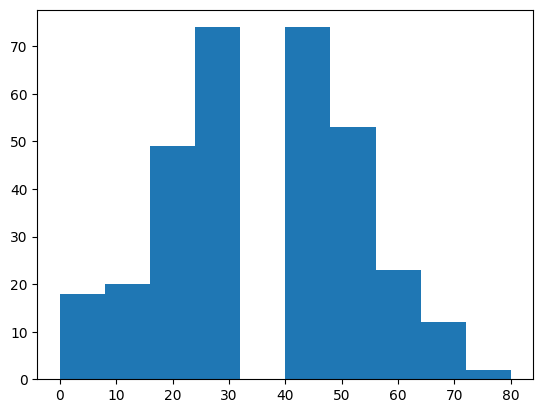

In [17]:
plt.hist(ifr)
print(stats.skew(ifr))
print(stats.kurtosis(ifr))

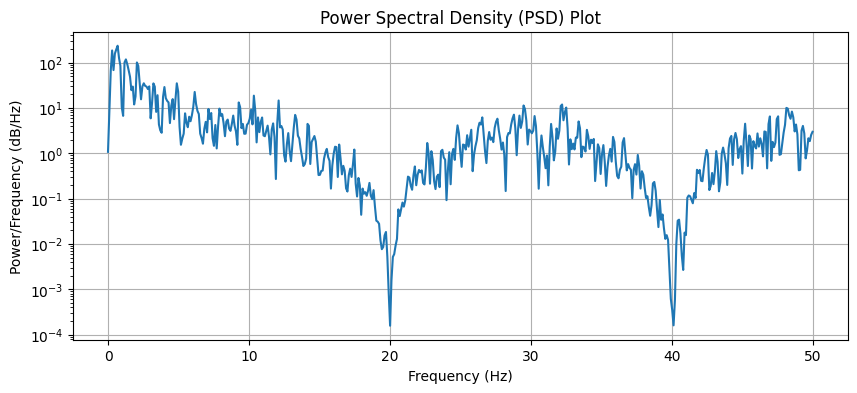

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Example data
fs = 100  # Sampling frequency in Hz

# Compute Power Spectral Density (PSD)
frequencies, psd = signal.welch(ifr, fs=fs, nperseg=1024)

# Plot the PSD
plt.figure(figsize=(10, 4))
plt.semilogy(frequencies, psd)
plt.title('Power Spectral Density (PSD) Plot')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()


### mean amplitude

In [53]:
def get_mean_amplitude(spike_times, recording, sampling_rate, window):
    amplitude_ls = []
    for spike in range(len(spike_times)):
        if spike_times[spike]*sampling_rate - window < 0:
            spike_segment = recording[0:int(spike_times[spike]*sampling_rate+window)]
            print('start spike')
        elif spike_times[spike]*sampling_rate + window > len(recording):
            spike_segment = recording[int(spike_times[spike]*sampling_rate-window):int(len(recording))]
            print('end spike')
        else:  
            spike_segment = recording[int(spike_times[spike]*sampling_rate-window):int(spike_times[spike]*sampling_rate+window)]
        
        # print(spike_segment)
        
        amplitude = np.max(spike_segment) - np.min(spike_segment)
        amplitude_ls.append(amplitude)
        # print(amplitude)
    mean_amplitude = np.mean(amplitude_ls)
    
    return mean_amplitude, amplitude_ls

# fig,ax=plt.subplots(4,4)
# ax=ax.ravel()
# i=0
for file in os.listdir(path):
    if file.endswith('.smr'):
        print(file)
        reader = neo.io.Spike2IO(os.path.join(path,file))
        block = reader.read(lazy=False)[0]
        segments = block.segments[0]

        analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
        spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
        sampling_frequency = float(segments.analogsignals[0].sampling_rate)
        mean_amplitude, amplitude_ls = get_mean_amplitude(spike_times, analogsignal, sampling_frequency, 20)
        # ax[i].hist(amplitude_ls, bins=20)
        # ax[i].set_title(f'{mean_amplitude:.3f}')
        # i=i+1
        print(mean_amplitude)

neuron_182.smr
3.1636337652439024
neuron_196.smr
0.8715250451090295
neuron_141.smr
1.6532094733927225
neuron_155.smr
0.36342420436686124
neuron_169.smr
2.1711601645259533
neuron_343.smr
3.6707431935501775
neuron_357.smr
0.9479908207254228
neuron_237.smr
1.0950600228658536
neuron_223.smr
1.1124564847797926
neuron_035.smr
0.5704319730718085
neuron_021.smr
0.8774201766304348
neuron_009.smr
0.05766444052419355
neuron_008.smr
0.444116485252809
neuron_020.smr
0.7286532204644638
neuron_034.smr
1.031851613340564
neuron_222.smr
0.6124890185742972
neuron_236.smr
1.3325273926654742
neuron_356.smr
2.2239759491711126
neuron_342.smr
2.494660481019053
neuron_168.smr
2.930571630658436
neuron_154.smr
start spike
0.19504147164096916
neuron_140.smr
0.23045548492076326
neuron_197.smr
1.1327847041034156
neuron_183.smr
3.1719031700721154
neuron_195.smr
1.1292370211693548
neuron_181.smr
2.129047704868562
neuron_156.smr
2.061121034861809
neuron_142.smr
start spike
0.9652635336229086
neuron_354.smr
1.476652759

0.0845947265625
0.5526123046875


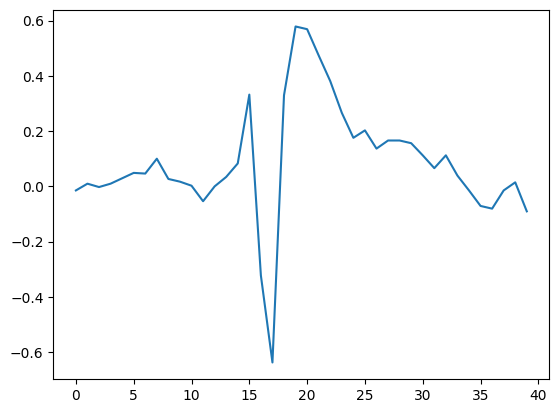

In [57]:
def get_mean_amplitude2(spike_times, recording, sampling_rate, window):
    amplitude_ls = []
    for spike in range(len(spike_times)):
        if spike_times[spike]*sampling_rate - window < 0:
            spike_segment = recording[0:int(spike_times[spike]*sampling_rate+window)]
            print('start spike')
        elif spike_times[spike]*sampling_rate + window > len(recording):
            spike_segment = recording[int(spike_times[spike]*sampling_rate-window):int(len(recording))]
            print('end spike')
        else:  
            spike_segment = recording[int(spike_times[spike]*sampling_rate-window):int(spike_times[spike]*sampling_rate+window)]
        
        baseline_mean = np.mean(spike_segment)
        
        amplitude = np.max(np.abs(spike_segment)) - baseline_mean
        amplitude_ls.append(amplitude)
        # print(amplitude)
    mean_amplitude = np.mean(amplitude_ls)
    
    return mean_amplitude, amplitude_ls

reader = neo.io.Spike2IO(filename)
block = reader.read(lazy=False)[0]
segments = block.segments[0]

analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
sampling_frequency = float(segments.analogsignals[0].sampling_rate) # the number of samples per second (in Hz)
time = np.arange(0,len(analogsignal))/sampling_frequency # time vector

mean_amplitude, amplitude_ls = get_mean_amplitude2(spike_times, analogsignal, sampling_frequency, 20)
# plt.hist(amplitude_ls)

plt.plot(analogsignal[int(spike_times[5] * sampling_frequency -20):int(spike_times[5]*sampling_frequency+20) ])
print(np.mean(analogsignal[int(spike_times[5] * sampling_frequency -20):int(spike_times[5]*sampling_frequency+20) ]))
print(amplitude_ls[5])

### Burst index

burst defined as preceding period of no spikes for 100ms and then spikes with ISI <4ms

In [78]:
def get_burst_index(spike_times):
    # silent for 100ms then next spike within 4ms
    ISI = [spike_times[i] - spike_times[i-1] for i in range(1,len(spike_times))]
    ISI_silent = [i for i,value in enumerate(ISI) if value>0.1]
    for putative_burst in ISI_silent:
    # print(spike_times[putative_burst] - spike_times[putative_burst-1])
        print(ISI[putative_burst] < 0.)
            
for file in os.listdir(path):
    if file.endswith('.smr'):
        print(file)
        reader = neo.io.Spike2IO(os.path.join(path,file))
        block = reader.read(lazy=False)[0]
        segments = block.segments[0]

        analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
        spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
        sampling_frequency = float(segments.analogsignals[0].sampling_rate)
        get_burst_index(spike_times)

neuron_182.smr
False
False
False
False
False
False
False
False
False
False
False
neuron_196.smr
neuron_141.smr
neuron_155.smr
neuron_169.smr
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
neuron_343.smr
False
False
False
False
False
False
False
neuron_357.smr
neuron_237.smr
neuron_223.smr
neuron_035.smr
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
neuron_021.smr
neuron_009.smr
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [ ]:
def get_burst_index2(spike_times):
    # spikes with ISI <150
    ISI = [spike_times[i] - spike_times[i-1] for i in range(1,len(spike_times))]
    
    for isi in ISI:
        if isi < 0.150:
            
for file in os.listdir(path):
    if file.endswith('.smr'):
        print(file)
        reader = neo.io.Spike2IO(os.path.join(path,file))
        block = reader.read(lazy=False)[0]
        segments = block.segments[0]

        analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
        spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
        sampling_frequency = float(segments.analogsignals[0].sampling_rate)
        get_burst_index(spike_times)

neuron_182.smr
[[3.24979625]]
neuron_196.smr
[[1.88757688]]
neuron_141.smr
[[1.79728302]]
neuron_155.smr
[[3.02081462]]
neuron_169.smr
[[3.76291578]]
neuron_343.smr
[[3.54875445]]
neuron_357.smr
[[1.31816578]]
neuron_237.smr
[[1.85530665]]
neuron_223.smr
[[1.21356328]]
neuron_035.smr
[[4.66129032]]
neuron_021.smr
[[1.18789697]
 [0.93591882]]
neuron_009.smr
[[2.0132914]]
neuron_008.smr
[[0.94024755]]
neuron_020.smr
[[1.20886364]]
neuron_034.smr
[[2.06243214]]
neuron_222.smr
[[0.89229391]]
neuron_236.smr
[[2.57296467]
 [2.00119474]]
neuron_356.smr
[[1.52201018]]
neuron_342.smr
[[7.69212963]]
neuron_168.smr
[[8.99834711]]
neuron_154.smr
[[1.75661376]]
neuron_140.smr
[[2.32176166]]
neuron_197.smr
[[1.61280101]]
neuron_183.smr
[[9.53001072]]
neuron_195.smr
[[16.74433657]]
neuron_181.smr
[[1.9763695]]


IndexError: index 25 is out of bounds for axis 0 with size 25

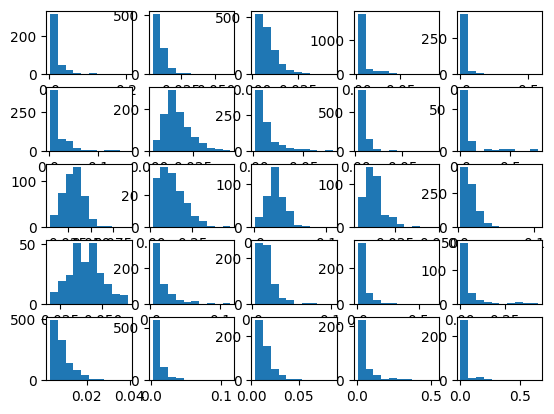

In [97]:
def get_burst_index3(spike_times):
    # ratio of mean ISI to mode ISI
    ISI = [round(spike_times[i] - spike_times[i-1],3) for i in range(1,len(spike_times))]
    isi_binned, counts = np.unique([isi for isi in ISI], return_counts=True) # rounding to millisecond
    # print(isi_binned)
    # print(counts)
    burst_index = np.mean(ISI) / isi_binned[np.argwhere(counts == np.amax(counts))]
    return ISI, burst_index

fig,ax=plt.subplots(5,5)
ax=ax.ravel()
i=0           
for file in os.listdir(path):
    if file.endswith('.smr'):
        print(file)
        reader = neo.io.Spike2IO(os.path.join(path,file))
        block = reader.read(lazy=False)[0]
        segments = block.segments[0]

        analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
        spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
        sampling_frequency = float(segments.analogsignals[0].sampling_rate)
        ISI, burst_index = get_burst_index3(spike_times)
        print(burst_index)
        ax[i].hist(ISI)
        i=i+1
        

In [110]:
reader = neo.io.Spike2IO(filename)
block = reader.read(lazy=False)[0]
segments = block.segments[0]

analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
sampling_frequency = float(segments.analogsignals[0].sampling_rate) # the number of samples per second (in Hz)
time = np.arange(0,len(analogsignal))/sampling_frequency # time vector

ISI = [spike_times[i] - spike_times[i-1] for i in range(1,len(spike_times))]
isi_binned, counts = np.unique([round(isi,3) for isi in ISI], return_counts=True) # rounding to millisecond
print(isi_binned)
print(counts)
len(isi_binned[np.argwhere(counts == 7)])
# for isi in ISI:
#     if isi < 0.150:
#         print(isi)

[0.001 0.002 0.004 0.005 0.008 0.01  0.011 0.012 0.013 0.014 0.015 0.016
 0.017 0.018 0.019 0.02  0.021 0.022 0.023 0.024 0.025 0.026 0.027 0.028
 0.029 0.03  0.031 0.032 0.033 0.034 0.035 0.036 0.037 0.038 0.039 0.04
 0.041 0.042 0.043 0.044 0.045 0.046 0.048 0.049 0.05  0.051 0.052 0.055
 0.056 0.057 0.058 0.059 0.061 0.062 0.063 0.067 0.069 0.07  0.071 0.075
 0.08  0.082 0.088 0.09  0.091 0.111 0.112 0.127 0.171 0.2   0.233 0.305
 0.334]
[ 1  2  1  1  3  2  7 15 28 20 27 25 16 32 22 34 23 21 23 18 18 18 19 14
 10 12 15 16  9  7 10  9  7  6  4  3  6  1  7  5  3  2  4  2  7  1  1  3
  2  2  1  2  1  1  3  1  1  1  1  2  1  1  1  1  1  1  1  1  1  1  1  1
  1]


5

To quantify the bursting activity of the GPi neurons, the Poisson surprise method of burst identification was used. In brief, bursts were defined as epochs of spiking activity with a Poisson surprise value >5. A bursting index was computed corresponding to the percentage of spikes in bursts compared to the total number of spikes recorded from a single unit (Neuro Explorer software; version 4). It is assumed that if the burst has “N” spikes and the distance from the first to the last spike of the burst is “T”, then the surprise of the burst is: S = −log P (i.e., the probability that P has at least N points in a time interval of length T).

https://link.springer.com/article/10.1007/s00702-015-1484-3

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.18666080341480268

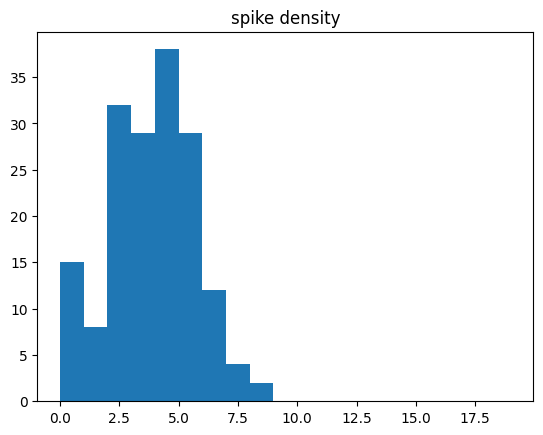

In [254]:
# Determine t and construct discharge density histogram

fr = get_firing_rate(spike_times, analogsignal, sampling_frequency)
t = 1/10

# hist, edges = np.histogram(spike_times, bins=np.arange(0, 16, t), density=True)
# plt.bar(edges[:-1], hist, width=t, align='edge')
spike_density,edges = np.histogram(spike_times,bins=np.arange(0,17,t),density=False)
density_bins = [i for i in range(0,20)]
plt.figure()
plt.hist(spike_density,bins=density_bins)
plt.title('spike density')

mu, std = stats.norm.fit(spike_density)

observed_frequencies, bins = np.histogram(spike_density, bins=density_bins)
bin_centers = (bins[:-1] + bins[1:]) / 2
expected_frequencies = stats.poisson.pmf(bin_centers, 1) * len(spike_density)

stats.chisquare(observed_frequencies, expected_frequencies)



#### rank surprise method

psuedo code from supp material of https://www-sciencedirect-com.myaccess.library.utoronto.ca/science/article/pii/S0165027006004742?via%3Dihub#app1

In [5]:
g_lim = 30 # limit for using real distribution
burst_spike_min = 3 # minimum number of spikes in a burst

significance_level = 0.05
RS_alpha = - np.log(significance_level)
ISI = np.diff(spike_times)
ISI_limit = np.percentile(ISI,75)
ISI_ranks = stats.rankdata(ISI)
sorted_ISI = np.sort(ISI)

archive_burst = []
current_burst = 0
current_RS = 0

# for i in range(0,)

#### neuroexplorer surprise method
https://plexon.com/wp-content/uploads/2017/06/NeuroExplorer-v5-Manual.pdf page 133

In [144]:
def burst_detection_neuroexplorer(spike_times, recording, sampling_rate, min_surprise, min_numspikes):
    
    burst_dict = {'burst_start_spike' : [],
              'burst_end_spike' : [],
              'burst_numspikes' : [],
              'burst_surprise' : []}

    mean_firing_rate = get_firing_rate(spike_times, recording, sampling_rate)
    mean_ISI = np.mean(np.diff(spike_times))
    # median_ISI = np.median(np.diff(spike_times))

    ISI_to_start_burst = mean_ISI / 2
    ISI_to_end_burst = mean_ISI

    ISI = np.diff(spike_times)
    j=0

    while j+1 < len(ISI):
        isi = ISI[j]
        surprise_list = []
        # print('ISI j', j)
        
        best_surprise = 0
        best_numspikes = 0
        burst_start_spike = 0
        burst_end_spike = 0
        
        if isi < ISI_to_start_burst and ISI[j+1] < ISI_to_start_burst:
            num_spikes = 3 # always starts with minimum 3 spikes
            surprise = - np.log10(np.exp(-mean_firing_rate) * np.power(mean_firing_rate, num_spikes) / np.math.factorial(num_spikes))
            surprise_list.append(surprise)
            best_surprise = surprise
            best_numspikes = num_spikes
            burst_start_spike = j
            burst_end_spike = j + num_spikes
            # add spike
            # if j + num_spikes -1 < len(ISI) == True:
            #     while ISI[j+num_spikes-1] < ISI_to_end_burst:
            while j + num_spikes - 1 < len(ISI) - 1 and ISI[j+num_spikes-1] < ISI_to_end_burst:
                    num_spikes = num_spikes + 1
                    surprise = - np.log10(np.exp(-mean_firing_rate) * np.power(mean_firing_rate, num_spikes) / np.math.factorial(num_spikes))
                    surprise_list.append(surprise)

                    if surprise >= best_surprise:
                        best_surprise = surprise
                        best_numspikes = num_spikes
                        # burst_start_spike = j # doesnt change until backward
                        burst_end_spike = j + best_numspikes
                
            # backward bursts
            backward_surprise_list = []
            for i in range(num_spikes,3,-1): # Start -1 because of spike to ISI conversion
                backward_surprise = - np.log10(np.exp(-mean_firing_rate) * np.power(mean_firing_rate, i) / np.math.factorial(i))
                backward_surprise_list.append(backward_surprise)
                if backward_surprise >= best_surprise:
                    best_surprise = backward_surprise
                    best_numspikes = i
                    # burst_end_spike = j + best_numspikes # doesnt change in backward
                    burst_start_spike = burst_end_spike - i
                
        if best_numspikes >= min_numspikes and best_surprise > min_surprise:
            # print('burst detected!')
            burst_dict['burst_start_spike'].append(burst_start_spike)
            burst_dict['burst_end_spike'].append(burst_end_spike)
            burst_dict['burst_numspikes'].append(best_numspikes)
            burst_dict['burst_surprise'].append(best_surprise)
            j = j + best_numspikes - 1
        else:
            j = j + 1
        
    return burst_dict

In [148]:
surprise_list = []
neuron_list = []
burst_spikes_list = []
for file in os.listdir(path):
    if file.endswith('.smr'):
        print(file)
        reader = neo.io.Spike2IO(os.path.join(path,file))
        block = reader.read(lazy=False)[0]
        segments = block.segments[0]

        analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
        spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
        sampling_frequency = float(segments.analogsignals[0].sampling_rate)

        burst_dict = burst_detection_neuroexplorer(spike_times, 
                                                   analogsignal, 
                                                   sampling_frequency, 
                                                   min_surprise = 3, 
                                                   min_numspikes = 3)
        surprise_list.extend(burst_dict['burst_surprise'])
        burst_spikes_list.extend(burst_dict['burst_numspikes'])
        neuron_list.extend([file] * len(burst_dict['burst_numspikes']))
        print(burst_dict)

neuron_182.smr
{'burst_start_spike': [3, 7, 10, 14, 17, 20, 22, 28, 31, 38, 42, 49, 54, 58, 61, 65, 68, 76, 81, 92, 95, 99, 105, 109, 111, 113, 120, 124, 127, 145, 159, 165, 168, 187, 189, 211, 216, 219, 231, 236, 241, 246, 248, 271, 274, 279, 287, 289, 292, 298, 300, 302, 304, 306, 312, 317, 320, 322, 326, 342, 346, 351, 359, 364, 375, 396, 399, 401, 403], 'burst_end_spike': [6, 10, 13, 17, 20, 23, 25, 31, 34, 41, 45, 52, 57, 61, 64, 68, 71, 79, 84, 95, 98, 102, 108, 112, 114, 116, 123, 127, 130, 148, 162, 168, 171, 190, 192, 214, 219, 222, 234, 239, 244, 249, 251, 274, 277, 282, 290, 292, 295, 301, 303, 305, 307, 309, 315, 320, 323, 325, 329, 345, 349, 354, 362, 367, 378, 399, 402, 404, 406], 'burst_numspikes': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'burst_surprise': [17.898021696272206, 17.898021696272206, 17.898021

In [150]:
np.unique(neuron_list,return_counts=True)

(array(['neuron_001.smr', 'neuron_002.smr', 'neuron_003.smr',
        'neuron_004.smr', 'neuron_006.smr', 'neuron_007.smr',
        'neuron_008.smr', 'neuron_010.smr', 'neuron_011.smr',
        'neuron_012.smr', 'neuron_013.smr', 'neuron_015.smr',
        'neuron_016.smr', 'neuron_017.smr', 'neuron_018.smr',
        'neuron_019.smr', 'neuron_020.smr', 'neuron_021.smr',
        'neuron_023.smr', 'neuron_024.smr', 'neuron_025.smr',
        'neuron_027.smr', 'neuron_028.smr', 'neuron_029.smr',
        'neuron_030.smr', 'neuron_031.smr', 'neuron_032.smr',
        'neuron_033.smr', 'neuron_034.smr', 'neuron_038.smr',
        'neuron_041.smr', 'neuron_042.smr', 'neuron_045.smr',
        'neuron_046.smr', 'neuron_047.smr', 'neuron_048.smr',
        'neuron_049.smr', 'neuron_050.smr', 'neuron_051.smr',
        'neuron_052.smr', 'neuron_053.smr', 'neuron_054.smr',
        'neuron_055.smr', 'neuron_057.smr', 'neuron_058.smr',
        'neuron_059.smr', 'neuron_060.smr', 'neuron_061.smr',
        

In [138]:
filename = "neuron_004.smr" # Name of the file including the extension (.smr)

reader = neo.io.Spike2IO(filename)
block = reader.read(lazy=False)[0]
segments = block.segments[0]

analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
sampling_frequency = float(segments.analogsignals[0].sampling_rate) # the number of samples per second (in Hz)
time = np.arange(0,len(analogsignal))/sampling_frequency # time vector

min_surprise = 5
burst_dict = {'burst_start_spike' : [],
              'burst_end_spike' : [],
              'burst_numspikes' : [],
              'burst_surprise' : []}

mean_firing_rate = get_firing_rate(spike_times, analogsignal, sampling_frequency)
mean_ISI = np.mean(np.diff(spike_times))
median_ISI = np.median(np.diff(spike_times))

ISI_to_start_burst = mean_ISI / 2
ISI_to_end_burst = mean_ISI

ISI = np.diff(spike_times)
j=0

while j+1 < len(ISI):
    isi = ISI[j]
    surprise_list = []
    print('ISI j', j)
    
    best_surprise = 0
    best_numspikes = 0
    burst_start_spike = 0
    burst_end_spike = 0
    
    if isi < ISI_to_start_burst and ISI[j+1] < ISI_to_start_burst:
        num_spikes = 3 # always starts with minimum 3 spikes
        surprise = - np.log10(np.exp(-mean_firing_rate) * np.power(mean_firing_rate, num_spikes) / np.math.factorial(num_spikes))
        surprise_list.append(surprise)
        best_surprise = surprise
        best_numspikes = num_spikes
        burst_start_spike = j
        burst_end_spike = j + num_spikes
        # add spike
        while ISI[j+num_spikes-1] < ISI_to_end_burst:
        # if j + num_spikes -1 < len(ISI) == True:
        #     while ISI[j+num_spikes-1] < ISI_to_end_burst:
                num_spikes = num_spikes + 1
                surprise = - np.log10(np.exp(-mean_firing_rate) * np.power(mean_firing_rate, num_spikes) / np.math.factorial(num_spikes))
                surprise_list.append(surprise)
                print('forward surprise', surprise, best_surprise)
                if surprise >= best_surprise:
                    print('forward best triggered')
                    best_surprise = surprise
                    best_numspikes = num_spikes
                    # burst_start_spike = j # doesnt change until backward
                    burst_end_spike = j + best_numspikes
                    print('best num spikes', best_numspikes)
            
        # backward bursts
        backward_surprise_list = []
        for i in range(num_spikes,3,-1): # Start -1 because of spike to ISI conversion
            backward_surprise = - np.log10(np.exp(-mean_firing_rate) * np.power(mean_firing_rate, i) / np.math.factorial(i))
            backward_surprise_list.append(backward_surprise)
            print('backward surprise', backward_surprise)
            if backward_surprise >= best_surprise:
                print('backward best triggered')
                best_surprise = backward_surprise
                best_numspikes = i
                # burst_end_spike = j + best_numspikes # doesnt change in backward
                burst_start_spike = burst_end_spike - i
                print('backward surprise', backward_surprise, best_surprise)
            
    if best_numspikes >= 3 and best_surprise > min_surprise:
        print('burst detected!')
        burst_dict['burst_start_spike'].append(burst_start_spike)
        burst_dict['burst_end_spike'].append(burst_end_spike)
        burst_dict['burst_numspikes'].append(best_numspikes)
        burst_dict['burst_surprise'].append(best_surprise)
        j = j + best_numspikes - 1
    else:
        j = j + 1
        

ISI j 0
ISI j 1
ISI j 2
ISI j 3
ISI j 4
ISI j 5
ISI j 6
ISI j 7
ISI j 8
ISI j 9
ISI j 10
ISI j 11
ISI j 12
ISI j 13
ISI j 14
ISI j 15
ISI j 16
ISI j 17
ISI j 18
ISI j 19
ISI j 20
ISI j 21
ISI j 22
ISI j 23
ISI j 24
ISI j 25
ISI j 26
ISI j 27
ISI j 28
ISI j 29
ISI j 30
ISI j 31
ISI j 32
ISI j 33
ISI j 34
ISI j 35
ISI j 36
ISI j 37
ISI j 38
ISI j 39
ISI j 40
ISI j 41
ISI j 42
ISI j 43
ISI j 44
ISI j 45
ISI j 46
ISI j 47
ISI j 48
ISI j 49
ISI j 50
ISI j 51
ISI j 52
ISI j 53
ISI j 54
ISI j 55
ISI j 56
ISI j 57
ISI j 58
ISI j 59
ISI j 60
ISI j 61
ISI j 62
ISI j 63
ISI j 64
ISI j 65
ISI j 66
ISI j 67
ISI j 68
ISI j 69
ISI j 70
ISI j 71
ISI j 72
ISI j 73
ISI j 74
ISI j 75
ISI j 76
ISI j 77
ISI j 78
ISI j 79
ISI j 80
ISI j 81
ISI j 82
ISI j 83
ISI j 84
ISI j 85
ISI j 86
ISI j 87
ISI j 88
ISI j 89
ISI j 90
ISI j 91
ISI j 92
ISI j 93
ISI j 94
ISI j 95
ISI j 96
ISI j 97
ISI j 98
ISI j 99
ISI j 100
ISI j 101
ISI j 102
ISI j 103
ISI j 104
ISI j 105
ISI j 106
ISI j 107
ISI j 108
ISI j 109
ISI j 110


In [139]:
burst_dict

{'burst_start_spike': [258],
 'burst_end_spike': [295],
 'burst_numspikes': [37],
 'burst_surprise': [5.105165961238634]}

In [141]:
burst_dict = burst_detection_neuroexplorer(spike_times, 
                                                   analogsignal, 
                                                   sampling_frequency, 
                                                   min_surprise = 5, 
                                                   min_numspikes = 4)

In [142]:
burst_dict

{'burst_start_spike': [258],
 'burst_end_spike': [295],
 'burst_numspikes': [37],
 'burst_surprise': [5.105165961238634]}

(array([ 2.,  3., 10., 21., 19., 16., 19.,  6.,  1.,  3.]),
 array([19. , 22.3, 25.6, 28.9, 32.2, 35.5, 38.8, 42.1, 45.4, 48.7, 52. ]),
 <BarContainer object of 10 artists>)

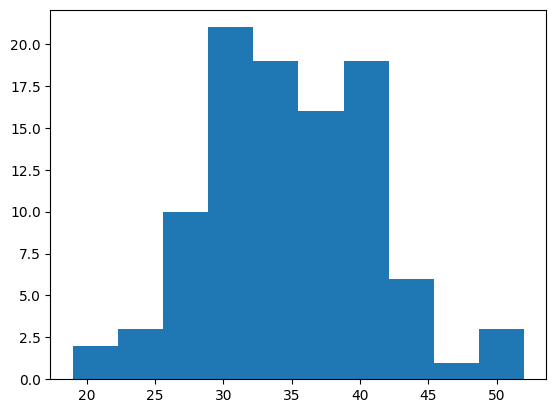

In [19]:
P = np.random.poisson(35,size=100)
plt.hist(P)

probability_at_least_N_spikes = 1 - np.sum(np.exp(-lambda_parameter) * 
                                           np.power(lambda_parameter, np.arange(N)) / 
                                           np.math.factorial(np.arange(N)))

### ISI metrics

neuron_182.smr
neuron_196.smr
neuron_141.smr
neuron_155.smr
neuron_169.smr
neuron_343.smr
neuron_357.smr
neuron_237.smr
neuron_223.smr
neuron_035.smr
neuron_021.smr
neuron_009.smr
neuron_008.smr
neuron_020.smr
neuron_034.smr
neuron_222.smr
neuron_236.smr
neuron_356.smr
neuron_342.smr
neuron_168.smr
neuron_154.smr
neuron_140.smr
neuron_197.smr
neuron_183.smr
neuron_195.smr
neuron_181.smr
neuron_156.smr
neuron_142.smr
neuron_354.smr
neuron_340.smr
neuron_220.smr
neuron_234.smr
neuron_208.smr
neuron_022.smr
neuron_036.smr
neuron_037.smr
neuron_023.smr
neuron_209.smr
neuron_235.smr
neuron_221.smr
neuron_341.smr
neuron_355.smr
neuron_143.smr
neuron_157.smr
neuron_180.smr
neuron_194.smr
neuron_190.smr
neuron_184.smr
neuron_153.smr
neuron_147.smr
neuron_351.smr
neuron_345.smr
neuron_219.smr
neuron_225.smr
neuron_231.smr
neuron_027.smr
neuron_033.smr
neuron_032.smr
neuron_026.smr
neuron_230.smr
neuron_224.smr
neuron_218.smr
neuron_344.smr
neuron_350.smr
neuron_146.smr
neuron_152.smr
neuron_185

ValueError: x must have 2 or fewer dimensions

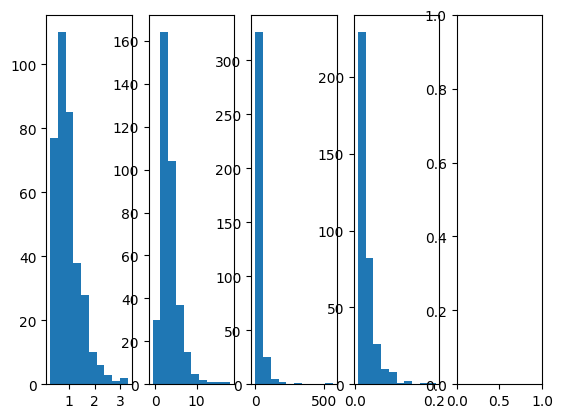

In [106]:
def get_ISI_metrics(spike_times):
    # ISI = [spike_times[i] - spike_times[i-1] for i in range(1,len(spike_times))]
    ISI = np.diff(spike_times)
    ISI_cv = np.std(ISI) / np.mean(ISI)
    ISI_skew = stats.skew(ISI)
    ISI_kurtosis = stats.kurtosis(ISI)
    ISI_mean = np.mean(ISI)
    isi_binned, counts = np.unique([round(isi,3) for isi in ISI], return_counts=True) # rounding to millisecond
    ISI_mode = isi_binned[np.argwhere(counts == np.amax(counts))] # may be binomial or multinomial, not used
    
    return ISI_cv, ISI_skew, ISI_kurtosis, ISI_mean, ISI_mode
 
ISI_cv_ls = []
ISI_skew_ls = []
ISI_kurtosis_ls = []
ISI_mean_ls = []
ISI_mode_ls = []   
for file in os.listdir(path):
    if file.endswith('.smr'):
        print(file)
        reader = neo.io.Spike2IO(os.path.join(path,file))
        block = reader.read(lazy=False)[0]
        segments = block.segments[0]

        analogsignal = np.array(segments.analogsignals[0],dtype='float64').transpose()[0] # raw analog waveform (unfiltered)
        spike_times = np.array(segments.events[0],dtype='float64') # spike timing array (i.e. exact time reletive to the start of the recording when a spike fired an action potential) 
        sampling_frequency = float(segments.analogsignals[0].sampling_rate)
        ISI_cv, ISI_skew, ISI_kurtosis, ISI_mean, ISI_mode = get_ISI_metrics(spike_times)
        ISI_cv_ls.append(ISI_cv)
        ISI_skew_ls.append(ISI_skew)
        ISI_kurtosis_ls.append(ISI_kurtosis)
        ISI_mean_ls.append(ISI_mean)
        ISI_mode_ls.append(ISI_mode)
        
plt.subplot(1,5,1)
plt.hist(ISI_cv_ls)
plt.subplot(1,5,2)
plt.hist(ISI_skew_ls)
plt.subplot(1,5,3)
plt.hist(ISI_kurtosis_ls)
plt.subplot(1,5,4)
plt.hist(ISI_mean_ls)
plt.subplot(1,5,5)
plt.hist(ISI_mode_ls)

In [107]:
ISI_mode_ls

[array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.02]]),
 array([[0.03]]),
 array([[0.06]]),
 array([[0.03]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.04]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.03]]),
 array([[0.1]]),
 array([[0.03]]),
 array([[0.02]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.02]]),
 array([[0.01]]),
 array([[0.04]]),
 array([[0.01]]),
 array([[0.04]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.02]]),
 array([[0.01]]),
 array([[0.04]]),
 array([[0.03]]),
 array([[0.01]]),
 array([[0.01]]),
 array([[0.02]]),
 array([[0.01]]),
 array([[0.04

### Oscillations

Most dominant frequency: 2.97 Hz
Significant frequencies:  [2.96969697 4.90909091]
Signiciant frequency bands:  ['delta', 'theta']


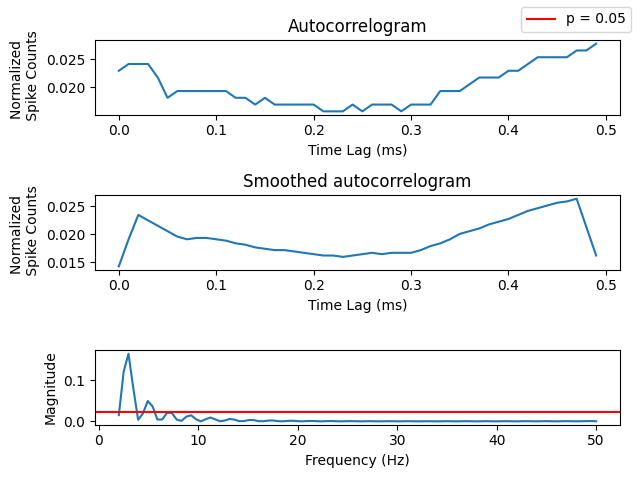

In [197]:
def get_synchrony_features(spike_times, 
                           time_bin_size = 0.01, 
                           max_lag_time = 0.5, 
                           avg_window_size = 5,
                           significance_level = 0.05, 
                           to_plot = False):
    # Create bins
    bins = np.arange(0, max_lag_time + time_bin_size, time_bin_size)

    # Initialize autocorrelogram
    autocorrelogram = np.zeros_like(bins[:-1], dtype=float)

    # Calculate autocorrelogram
    for i in range(len(bins) - 1):
        time_lag = bins[i]
        spike_pairs = spike_times[(spike_times >= time_lag) & (spike_times < time_lag + max_lag_time)]
        autocorrelogram[i] = len(spike_pairs)

    # Normalize autocorrelogram
    autocorrelogram /= np.sum(autocorrelogram)
    moving_avg_window = np.ones(avg_window_size) / avg_window_size
    smoothed_autocorrelogram = signal.convolve(autocorrelogram, moving_avg_window, mode='same')
    
    w = np.linspace(2*2*np.pi, 50*2*np.pi, 100)
    pgram = signal.lombscargle(bins[:-1], smoothed_autocorrelogram, w, normalize=True)
    
    # Calculate the threshold based on the significance level
    threshold = np.percentile(pgram, (1 - significance_level) * 100)
    
    peaks, peak_props = signal.find_peaks(pgram, height=threshold)
    freq_peaks = w[peaks] / (2*np.pi)
    max_peak_freq = w[peaks[peak_props['peak_heights'].argmax()]] / (2* np.pi)

    frequency_bands = {
        'delta': (0.1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50),
    }

    peak_bands = []
    for band, (lower, upper) in frequency_bands.items():
        peak_bands.extend([band for p in freq_peaks if lower <= p < upper])
    
    if to_plot == True:
        fig,axes = plt.subplots(3,1)
        axes[0].plot(bins[:-1], autocorrelogram)
        axes[0].set_title('Autocorrelogram')
        axes[0].set_xlabel('Time Lag (ms)')
        axes[0].set_ylabel('Normalized \n Spike Counts')
        
        axes[1].plot(bins[:-1], smoothed_autocorrelogram)
        axes[1].set_xlabel('Time Lag (ms)')
        axes[1].set_ylabel('Normalized \n Spike Counts')
        axes[1].set_title('Smoothed autocorrelogram')
        
        axes[2].plot(w/(2*np.pi), pgram)
        axes[2].axhline(y=threshold, color='r', label='p = ' + str(significance_level))
        axes[2].set_ylabel('Magnitude')
        axes[2].set_xlabel('Frequency (Hz)')
        
        fig.legend()
        fig.tight_layout()
    
    return max_peak_freq, freq_peaks, peak_bands

max_peak_freq, freq_peaks, peak_bands = get_synchrony_features(spike_times, 
                                                               time_bin_size = 0.01, 
                                                               max_lag_time = 0.5, 
                                                               avg_window_size = 5,
                                                               significance_level = 0.05, 
                                                               to_plot = True)

print(f'Most dominant frequency: {max_peak_freq:.2f} Hz')
print('Significant frequencies: ', freq_peaks)
print('Signiciant frequency bands: ', peak_bands)

max peak freq:  2.9696969696969697
significant peak frequencies (Hz):  [2.96969697 4.90909091]
['delta', 'theta']


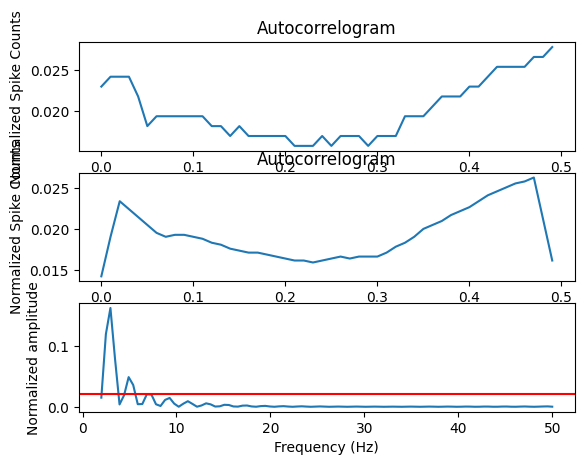

In [190]:
time_bin_size = 0.01  # in milliseconds
max_lag_time = 0.5  # in milliseconds

# Create bins
bins = np.arange(0, max_lag_time + time_bin_size, time_bin_size)

# Initialize autocorrelogram
autocorrelogram = np.zeros_like(bins[:-1], dtype=float)

# Calculate autocorrelogram
for i in range(len(bins) - 1):
    time_lag = bins[i]
    spike_pairs = spike_times[(spike_times >= time_lag) & (spike_times < time_lag + max_lag_time)]
    autocorrelogram[i] = len(spike_pairs)

# Normalize autocorrelogram
autocorrelogram /= np.sum(autocorrelogram)
moving_avg_window = np.ones(5) / 5
smoothed_autocorrelogram = signal.convolve(autocorrelogram, moving_avg_window, mode='same')

# Plot autocorrelogram
plt.subplot(3,1,1)
plt.plot(bins[:-1], autocorrelogram)
plt.xlabel('Time Lag (ms)')
plt.ylabel('Normalized Spike Counts')
plt.title('Autocorrelogram')

# Plot autocorrelogram
plt.subplot(3,1,2)
plt.plot(bins[:-1], smoothed_autocorrelogram)
plt.xlabel('Time Lag (ms)')
plt.ylabel('Normalized Spike Counts')
plt.title('Autocorrelogram')

w = np.linspace(2*2*np.pi, 50*2*np.pi, 100)
pgram = signal.lombscargle(bins[:-1], smoothed_autocorrelogram, w, normalize=True)
# Set the significance level (p-value)
significance_level = 0.05
# Calculate the threshold based on the significance level
threshold = np.percentile(pgram, (1 - significance_level) * 100)

plt.subplot(3,1,3)
plt.plot(w/(2*np.pi), pgram)
plt.axhline(y=threshold, color='r')
plt.ylabel('Normalized amplitude')
plt.xlabel('Frequency (Hz)')

peaks, peak_props = signal.find_peaks(pgram, height=threshold)
freq_peaks = w[peaks] / (2*np.pi)
max_peak = w[peaks[peak_props['peak_heights'].argmax()]] / (2* np.pi)
print('max peak freq: ', max_peak)
print('significant peak frequencies (Hz): ', freq_peaks)

frequency_bands = {
    'delta': (0.1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 50),
}

peak_bands = []
for band, (lower, upper) in frequency_bands.items():
    peak_bands.extend([band for p in freq_peaks if lower <= p < upper])
print(peak_bands)

Burst detector code https://github.com/tk-neuron/ISIn/blob/main/ISIn/burst_detector.py